# Case Study

## Company Background
GoalZone is a fitness club chain providing five types of fitness classes in Canada. Finally, the fitness classes schedule is back to normal after the COVID-19 restrictions are lifted. However, they have received many complaints from the customers about having a hard time booking a fitness class.

From initial analysis, the program operation team found out that the fitness classes are always fully booked but are having a low attendance rate per class. To improve this situation, they would like to increase the class capacity for customers to sign up if a low attendance rate is predicted.  


## Customer Question
The operation manager has asked you to answer the following:
- Can you predict the attendance rate for each fitness class? 



## Dataset
The dataset contains the attendance information for the class scheduled this year so far. The data you will use for this analysis can be accessed here: `"data/fitness_class.csv"`

| Column Name                     | Criteria                                                                                                                                                                        |
|---------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Day of Week                     | Character, the day of the week the class was scheduled, one of values from “Mon” to “Sun”.                                                                                      |
| Time                            | Character, the time of the day the class was scheduled, either "AM" or "PM".                                                                                                        |
| Class Category                  | Character, the category of the fitness class, one of “Yoga”, “Aqua”, “Strength”, “HIIT”, or “Cycling”.                                                                          |
| Days Before                     | Numeric, number of days the class stayed fully booked, maximum five days.                                                                                                       |
| Class Capacity                  | Numeric, maximum number of members can sign up for that class, either 15 or 25.  The class capacity being 26 needs to be updated to 25.                                         |
| Attendance                      | Numeric, number of members actually attended the class.                                                                                                                         |
| Average Age                     | Numeric, average age of the members signing up for that class.  Remove rows that average age is smaller than 14 because group fitness class are for members aged 14 and order.  |
| Number of New Students          | Numeric, number of new students signing up for this class.                                                                                                                      |
| Number of Members Over 6 months | Numeric, number of members signing up for the class have been joining the club more than 6 months.                                                                              |                                                                                     |

## All imports

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor

import tensorflow as tf

plt.style.use("seaborn")

## Reading Data

In [79]:
# Data Validation
# Check all variables in the data against the criteria in the dataset above
fp = "/content/drive/MyDrive/Colab Notebooks/DataScience Solutions/In house Project/Case Study fitness attendences/data/fitness_class.csv"
df = pd.read_csv(fp)
# Start coding here... 
df.head()

,day_of_week,time,class_category,class_capacity,days_before,attendance,age,new_students,over_6_month
0,Wed,AM,Yoga,15,1,8,31.1,6,4
1,Sun,PM,Aqua,15,3,8,27.0,7,8
2,Mon,AM,Aqua,15,5,10,22.4,8,7
3,Sun,PM,Strength,25,3,18,23.5,7,9
4,Mon,AM,Yoga,15,5,10,29.8,5,7


This dataset luckily doesn't contains any missing or corrupt values. And also the dtypes are just fine.
However following two changes are made.
1. In class capacity variable. 26 is upgraded to 25 as there's no class with the maximum capacity of 26. It is either 15 or 25.
2. Rows with values of age column below 14 are droped, only rows with age column values above 14 or equal to 14 are retained as it is the company policy that only people of ages 14 or older are allowed 

In [80]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   day_of_week     765 non-null    object 
 1   time            765 non-null    object 
 2   class_category  765 non-null    object 
 3   class_capacity  765 non-null    int64  
 4   days_before     765 non-null    int64  
 5   attendance      765 non-null    int64  
 6   age             765 non-null    float64
 7   new_students    765 non-null    int64  
 8   over_6_month    765 non-null    int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 53.9+ KB


In [81]:
df.isna().sum() # To see is there any missing values

day_of_week       0
time              0
class_category    0
class_capacity    0
days_before       0
attendance        0
age               0
new_students      0
over_6_month      0
dtype: int64

In [82]:
df.dtypes # Checking dtypes of the columns

day_of_week        object
time               object
class_category     object
class_capacity      int64
days_before         int64
attendance          int64
age               float64
new_students        int64
over_6_month        int64
dtype: object

In [83]:
# Updating 26 to 25 in class capacity variable
df["class_capacity"] = np.where(df["class_capacity"].isin([26,25]), 25, 15)

In [84]:
# Removing rows where the age of the person is 14 or less
df = df[df["age"] >= 14]

## Expoloratory Data Analysis

### Results of EDA
Ok! So in this section I've done my EDA which has show me that.
- There are 3 non-numeric variable and 6 numeric variables.
- The age variable is normally distributed with **mean** of **29** and **Standard Deviation** of **6**
- Among all the weekdays they provided fitness classes, **Sunday** seems most populated. But it doesn't seems the difference is any significiant to me.
- And most people attend at evening time.
- Most people like to attend yoga class than other classes provided by this club. But again not a big difference.
- But classes where the capacity is 25 are more populated than classes where the capacity is 15. And this difference is **statistically** significiant with **p-value** of **3.72 * 10^-92**
- And majority of the classes are with the capacity 25 (75%) not 15 (25%).
- Luckily variable aren't very correlated among themselves.
3 variable has shown some correlation with our predictor variable attendence. And is natural to have that.
  - attendance and class_capacity has a corr of 0.65. Not highly significiant but yet a correlation
  - attendance and over_6_month has corr of 0.7. As the person becomes more elder in club its attendance rate increase. That's pretty common everywhere right?.
  - attendance and age has corr of -0.73. As we all know as the age increases the person is less likely to do excercises.

In [85]:
df.describe()

,class_capacity,days_before,attendance,age,new_students,over_6_month
count,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000
mean,17.506562,2.547244,9.519685,29.163648,5.912073,7.565617
std,4.336755,1.355768,3.841164,5.812547,1.788821,1.968617
min,15.000000,1.000000,4.000000,14.000000,1.000000,2.000000
25%,15.000000,1.000000,7.000000,25.300000,5.000000,6.000000
50%,15.000000,2.000000,9.000000,29.000000,6.000000,8.000000
75%,22.500000,4.000000,11.000000,33.200000,7.000000,9.000000
max,25.000000,5.000000,21.000000,48.800000,11.000000,13.000000


In [86]:
df.describe(include="object")

,day_of_week,time,class_category
count,762,762,762
unique,7,2,5
top,Thu,PM,Yoga
freq,126,395,173


### Exploring non numeric Variables

In [87]:
df.select_dtypes(include="object").head()

,day_of_week,time,class_category
0,Wed,AM,Yoga
1,Sun,PM,Aqua
2,Mon,AM,Aqua
3,Sun,PM,Strength
4,Mon,AM,Yoga


#### Day of week variable

In [88]:
df["day_of_week"].unique()

array(['Wed', 'Sun', 'Mon', 'Tue', 'Thu', 'Sat', 'Fri'], dtype=object)

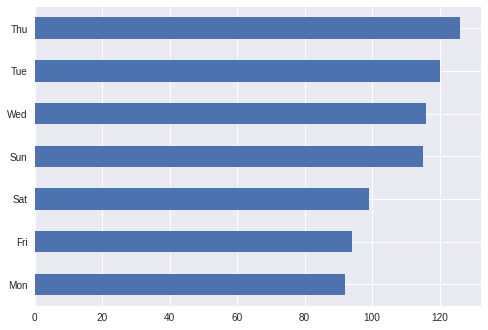

In [89]:
df['day_of_week'].value_counts().sort_values(ascending=True).plot(kind="barh")
plt.show()

#### Time Variable

In [90]:
df["time"].unique()

array(['AM', 'PM'], dtype=object)

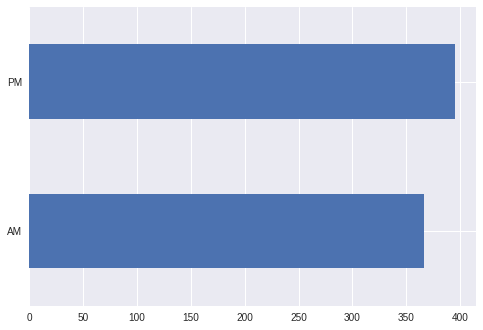

In [91]:
df["time"].value_counts(ascending=True).plot(kind="barh")
plt.show()

#### Class Category Variable

In [92]:
df["class_category"].unique()

array(['Yoga', 'Aqua', 'Strength', 'HIIT', 'Cycling'], dtype=object)

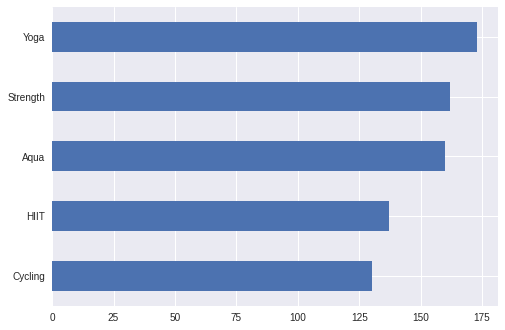

In [93]:
df["class_category"].value_counts(ascending=True).plot(kind="barh")
plt.show()

### Exploring numerical Variables

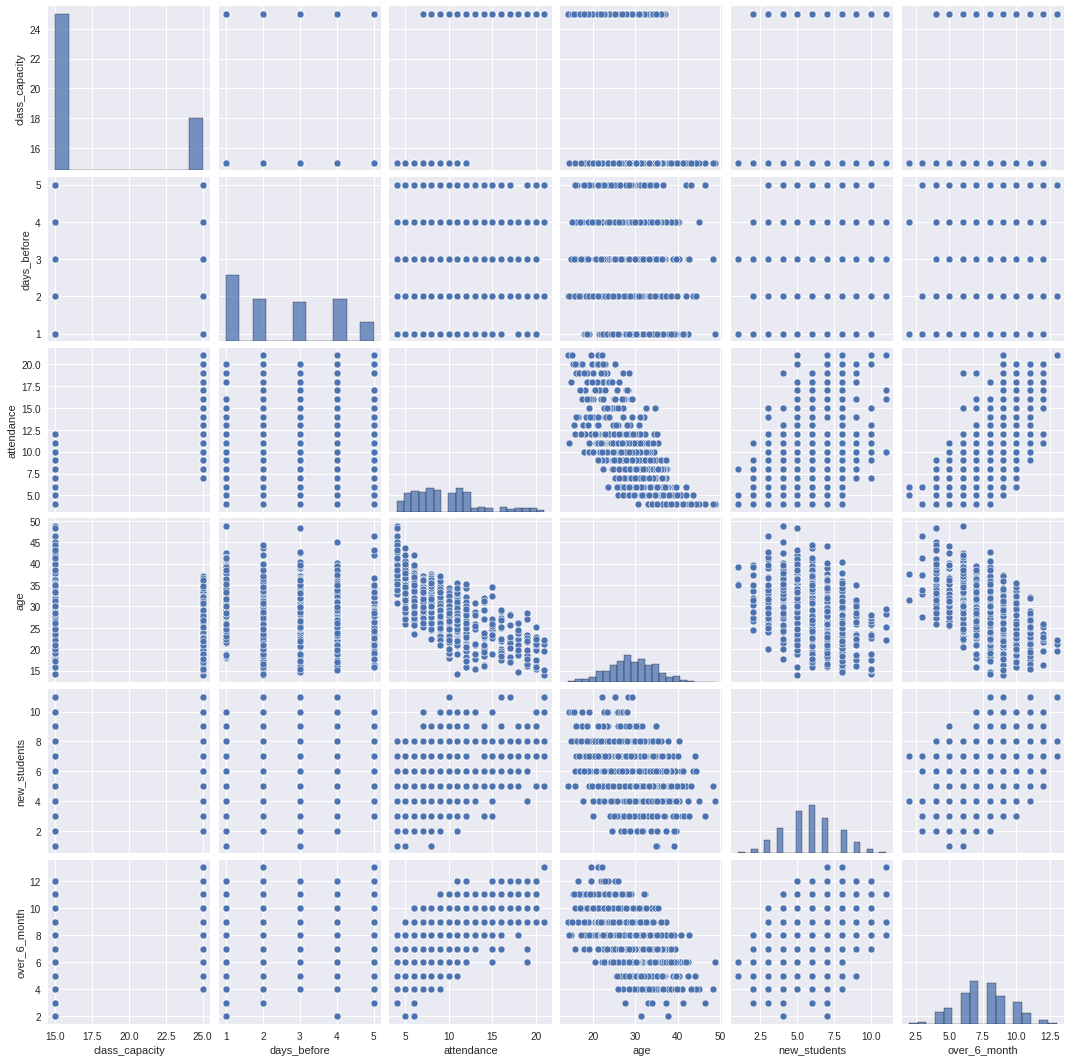

In [94]:
sns.pairplot(df.select_dtypes(exclude="object"))
plt.show()

#### Class capacity variable

In [95]:
# See the class capacity variable
df["class_capacity"].unique()

array([15, 25])

In [96]:
df["class_capacity"].value_counts(normalize=True)

15    0.749344
25    0.250656
Name: class_capacity, dtype: float64

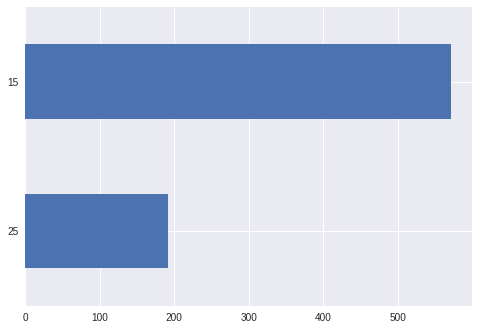

In [97]:
df["class_capacity"].value_counts(ascending=True).plot(kind="barh")
plt.show()

#### Days before variable

In [98]:
df["days_before"].unique()

array([1, 3, 5, 4, 2])

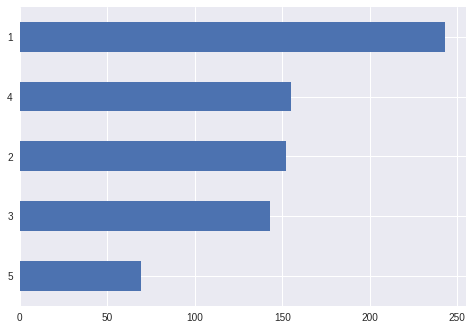

In [99]:
df["days_before"].value_counts(ascending=True).plot(kind="barh")
plt.show()

#### New students

In [100]:
df["new_students"].unique()

array([ 6,  7,  8,  5,  4,  3,  2,  9, 10, 11,  1])

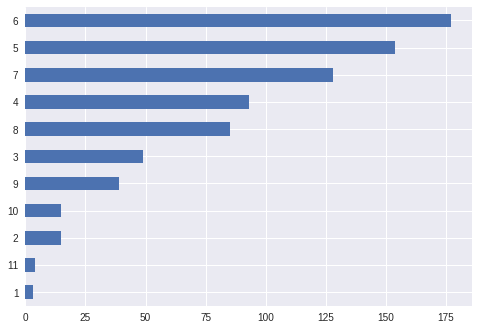

In [101]:
df["new_students"].value_counts(ascending=True).plot(kind="barh")
plt.show()

#### Over 6 month variable

In [102]:
df["over_6_month"].unique()

array([ 4,  8,  7,  9, 11,  6,  5,  3, 12, 10, 13,  2])

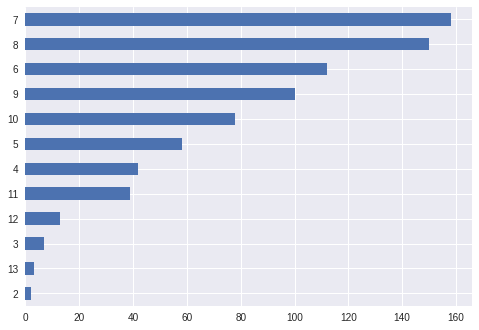

In [103]:
df["over_6_month"].value_counts(ascending=True).plot(kind="barh")
plt.show()

#### Age variable

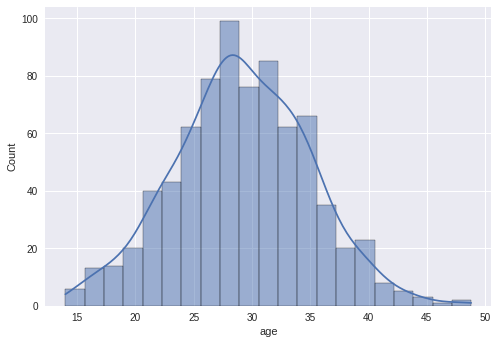

In [104]:
sns.histplot(df["age"], kde=True)
plt.show()

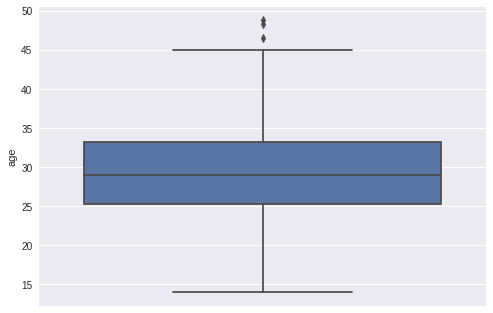

In [105]:
sns.boxplot(y=df["age"])
plt.show()

#### Attendance variable

In [106]:
df["attendance"].unique()

array([ 8, 10, 18,  7, 15, 20,  5, 12,  9,  6, 19, 13, 11,  4, 16, 14, 21,
       17])

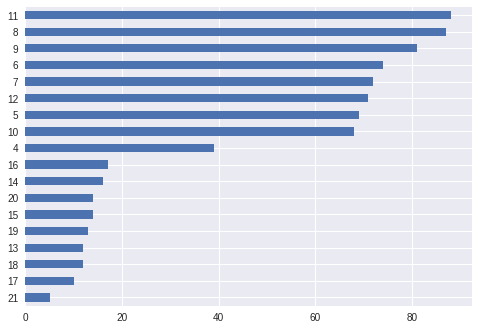

In [107]:
df["attendance"].value_counts(ascending=True).plot(kind="barh")
plt.show()

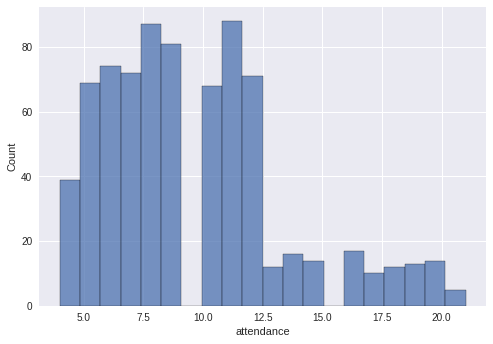

In [108]:
sns.histplot(df["attendance"])
plt.show()

### Attendence Rate

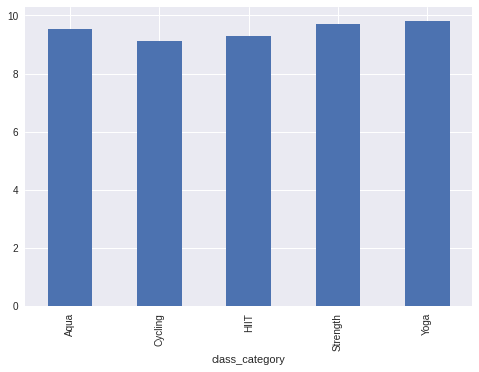

In [109]:
df.groupby("class_category")["attendance"].mean().plot(kind="bar")
plt.show()

# Most of the people seems to attend yoga class but there doesn't seem pretty much of different ammong these classes

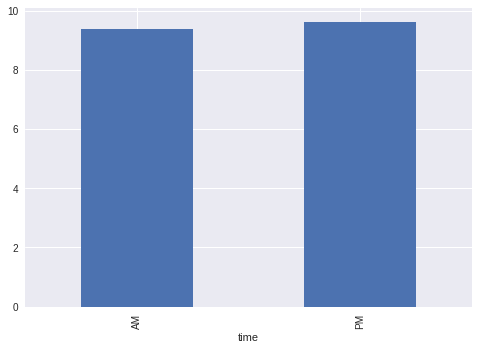

In [110]:
df.groupby("time")["attendance"].mean().plot(kind="bar")
plt.show()

# Doesn't seems to have a lot of difference to me

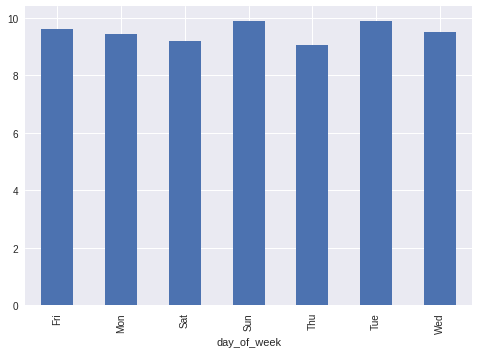

In [111]:
df.groupby("day_of_week")["attendance"].mean().plot(kind="bar")
plt.show()

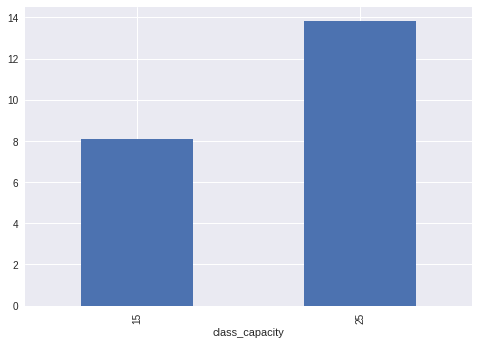

In [112]:
df.groupby("class_capacity")["attendance"].mean().plot(kind="bar")
plt.show()

In [113]:
a = df.loc[df["class_capacity"]==15, "attendance"]
b = df.loc[df["class_capacity"]==25, "attendance"]

_, pval = stats.ttest_ind(a, b)

if pval < 0.05:
  print(f"There's statistically significiant difference with p value of {pval}")
else:
  print("Nope")

There's statistically significiant difference with p value of 6.593542972783837e-93


### Visualizing correlation between variables

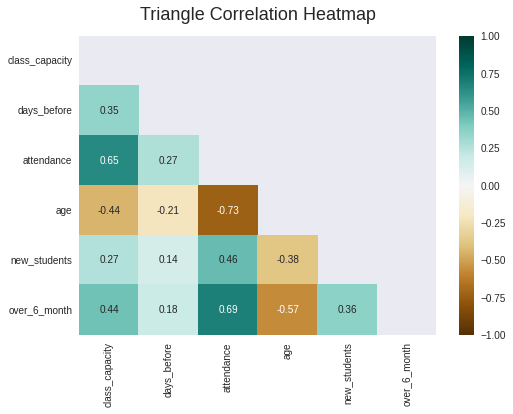

In [114]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.show()

Following variable seems to have significiant correlation.
* attendance and class_capacity has a corr of 0.65
* attendance and over_6_month has corr of 0.7
* attendance and age has corr of -0.73

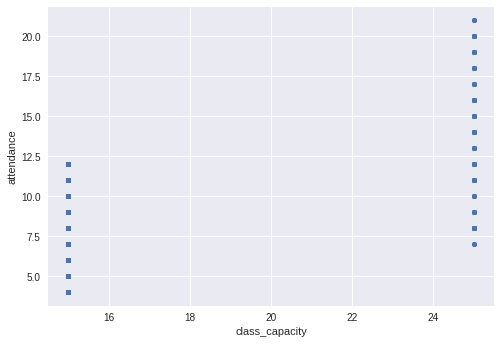

In [115]:
df.plot(
    x="class_capacity",
    y="attendance",
    kind="scatter"
)
plt.show()

The class capacity variable only contains either 15 or 25. As we know the capacity is the more people can fit in.

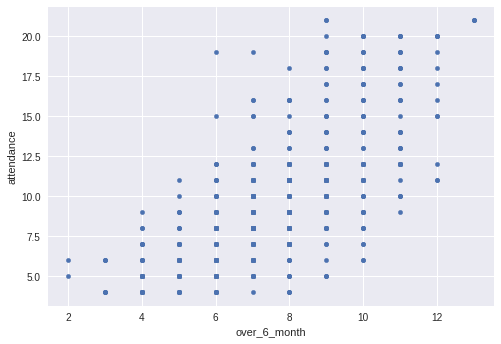

In [116]:
df.plot(
    x="over_6_month",
    y="attendance",
    kind="scatter"
)
plt.show()

As the person becomes more elder in club it attendance rate increase. That's pretty common everywhere

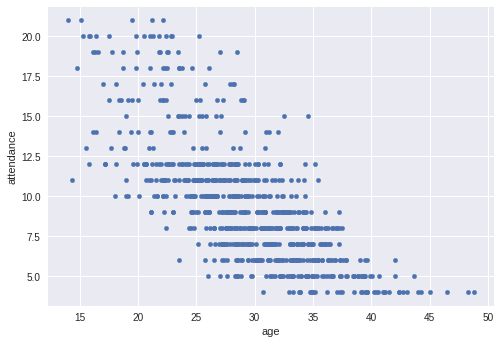

In [117]:
df.plot(
    x="age",
    y="attendance",
    kind="scatter"
)
plt.show()

As we all know as the age increases the person is less likely to do excercises.

## Model Fitting

### To solve our Regression Problem

### At first I did some preprocessing
1. Seperate dependent and independent variables.
2. Encode the categorical variables using one hot encoding technique
3. Split the dataset into 85% training and 15% testing set
4. At last normalize the dataset

#### Next Model Building Part
- I chosed Dummy Regressor as my baseline model because it use mean value of our predictor and it seems a best baseline model to me, super easy to maintain.
- I tried different models complex and simple. These three models seems to me were the best of all
  1. Simple linear Regression: for just 792 data point it seems quite great model. 
  2. Random Forest Regressor: for 792 data points and with n_estimators=15, max_depth=6, max_leaf_nodes=13, it performed really well.
  3. Deep Neural Network: As the name suggest our latest models. Because the data points were just 792 therefore they didn't gave super great accuracy like it's popularity but it showed us reliable accuracy.

Last words before we move on. The accuracy was 75%+ but if we were supplied with more data points it can be increased and random Forest Regressor model is our reliable model

### Preprocessing

In [118]:
X = df.drop(columns="attendance")
y = df["attendance"]

#### Encoding categorical data

In [119]:
X = pd.get_dummies(X, drop_first=True)

#### Train test split

Splitting the data into 85% training and 15% testing

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [121]:
print("The shape of X_train is", X_train.shape, " and of y_train is", y_train.shape)
print("The shape of X_test is", X_test.shape, " and of y_test is", y_test.shape)

The shape of X_train is (647, 16)  and of y_train is (647,)
The shape of X_test is (115, 16)  and of y_test is (115,)


#### Normalizing age variable

In [122]:
mms = MinMaxScaler()

mms.fit(X_train[["age"]])

X_train["age"] = mms.transform(X_train[["age"]])
X_test["age"] = mms.transform(X_test[["age"]])

### Model Building

In [123]:
# Baseline Model

baselineModel = DummyRegressor()
baselineModel.fit(X_train, y_train)

print("The training accuracy is", baselineModel.score(X_train, y_train))
print("The testing accuracy is", baselineModel.score(X_test, y_test))

The training accuracy is 0.0
The testing accuracy is -0.0031297077561949216


In [124]:
# Linear Regression Model

lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)

print("The training accuracy is", lr.score(X_train, y_train))
print("The testing accuracy is", lr.score(X_test, y_test))

The training accuracy is 0.75509912076994
The testing accuracy is 0.747060838162281


In [125]:
# RandomForestModel

rfr = RandomForestRegressor(n_estimators=15, max_depth=6, max_leaf_nodes=13, random_state=42)
rfr.fit(X_train, y_train)

print("The training accuracy is", rfr.score(X_train, y_train))
print("The testing accuracy is", rfr.score(X_test, y_test))

The training accuracy is 0.7801466192858674
The testing accuracy is 0.7619528874224452


In [126]:
## Deep learning model 
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=[X_train.shape[-1]]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(8),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(1)
])

model.compile(
    loss="mse",
    optimizer="adam",
)

model.fit(X_train, y_train,
          epochs=1000,
          batch_size=32,
          verbose=0,
          validation_data =(X_test, y_test))


y_predDeepTrain = model.predict(X_train)
y_predDeepTest = model.predict(X_test)

print("The training accuracy is",r2_score(y_train, y_predDeepTrain))
print("The testing accuracy is", r2_score(y_test, y_predDeepTest))

The training accuracy is 0.7933824677279976
The testing accuracy is 0.7339997716491236


## Model Evaluation

### To evaluate our models

- **I** chosed the best metrics like R2 score, mean squared error, root mean squarred error and mean absolute error to compare the models, as they are nowadays used for regression problem
- The following table shows the comparision of these metrics with the models. Hence the minimum error we can get is 1.51 and maximum r2 score we can get is 76%
- By seeing the table Random Forest Regressor Model has best predictions

In [127]:
# Model Evaluation
# Choose a metric and evaluate the performance of the two models

# Start coding here... 
mse_baseline = mean_squared_error(y_test, baselineModel.predict(X_test))
mse_lr = mean_squared_error(y_test, lr.predict(X_test))
mse_rf = mean_squared_error(y_test, rfr.predict(X_test))
mse_dr = mean_squared_error(y_test, model.predict(X_test))

rmse_baseline = np.sqrt(mean_squared_error(y_test, baselineModel.predict(X_test)))
rmse_lr = np.sqrt(mean_squared_error(y_test, lr.predict(X_test)))
rmse_rf = np.sqrt(mean_squared_error(y_test, rfr.predict(X_test)))
rmse_dr = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

mae_baseline = mean_absolute_error(y_test, baselineModel.predict(X_test))
mae_lr = mean_absolute_error(y_test, lr.predict(X_test))
mae_rf = mean_absolute_error(y_test, rfr.predict(X_test))
mae_dr = mean_absolute_error(y_test, model.predict(X_test))

r2_baseline = r2_score(y_test, baselineModel.predict(X_test))
r2_lr = r2_score(y_test, lr.predict(X_test))
r2_rf = r2_score(y_test, rfr.predict(X_test))
r2_dr = r2_score(y_test, model.predict(X_test))

In [128]:
metrics = pd.DataFrame(
    data = {
        "Metrics": ["r2 score", "mean squared error", "root mean squared error", "mean absolute error"],
        "Baseline Model": [r2_baseline, mse_baseline, rmse_baseline, mae_baseline],
        "Linear Regression": [r2_lr, mse_lr, rmse_lr, mae_lr],
        "Random Forrest Regressor": [r2_rf, mse_rf, rmse_rf, mae_rf],
        "Deep Neural Network": [r2_dr, mse_dr, rmse_dr, mae_dr],
    }
)

metrics

,Metrics,Baseline Model,Linear Regression,Random Forrest Regressor,Deep Neural Network
0,r2 score,-0.003130,0.747061,0.761953,0.734000
1,mean squared error,15.923101,4.015010,3.778622,4.222334
2,root mean squared error,3.990376,2.003749,1.943868,2.054832
3,mean absolute error,3.086432,1.555230,1.518255,1.542788


# The final Answer

## Customer Question Recal
The operation manager has asked you to answer the following:
- Can you predict the attendance rate for each fitness class? 

## Customer Question Answer
- **Yes you can predict the attendance rate for each fitness class**

And for this purpose we can easily use **Random Forest Regressor**. We don't need a very complex model like Deep Neural Network. Hence more data would be helpful in improving the accuracy